In [1]:
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.decomposition

import sys
sys.path.append('../')
import paradime.routines
import paradime.utils
import paradime.relations
import paradime.transforms
import paradime.loss
import paradime.dr

In [2]:
mnist = torchvision.datasets.MNIST(
    '../data',
    train=True,
    download=True,
)

In [3]:
num_pts = 5000
testdata = mnist.data.reshape(-1, 28*28) / 255.
testdata = testdata[:num_pts][np.argsort(mnist.targets[:num_pts])]
testtargets = np.sort(mnist.targets[:num_pts])

In [5]:
# paradime.utils.seed_all(42)
foo = paradime.routines.ParametricTSNE(
    perplexity=100,
    dataset=testdata,
    init_epochs=10,
    epochs=30,
    batch_size=500,
    learning_rate=0.01,
    use_cuda=True,
    verbose=True
)
with torch.autograd.set_detect_anomaly(True):
    foo.train()

2022-08-08 16:28:09,173: Registering dataset.
2022-08-08 16:28:09,312: Adding entry 'pca' to dataset.
2022-08-08 16:28:09,313: Computing global relations 'rel'.
2022-08-08 16:28:09,315: Indexing nearest neighbors.
2022-08-08 16:28:31,583: Calculating probabilities.
2022-08-08 16:28:32,460: Beginning training phase 'pca_init'.
2022-08-08 16:28:35,238: Loss after epoch 0: 436.7036819458008
2022-08-08 16:28:39,176: Loss after epoch 5: 228.8800573348999
2022-08-08 16:28:42,362: Beginning training phase 'embedding'.
2022-08-08 16:28:43,460: Loss after epoch 0: -0.0001482998604842578
2022-08-08 16:28:48,924: Loss after epoch 5: -0.00015074054772412637
2022-08-08 16:28:54,294: Loss after epoch 10: -0.00015276844533218537
2022-08-08 16:28:59,944: Loss after epoch 15: -0.0001479693382862024
2022-08-08 16:29:05,411: Loss after epoch 20: -0.00015079245895321947
2022-08-08 16:29:10,914: Loss after epoch 25: -0.00014735023069079034


<AxesSubplot:>

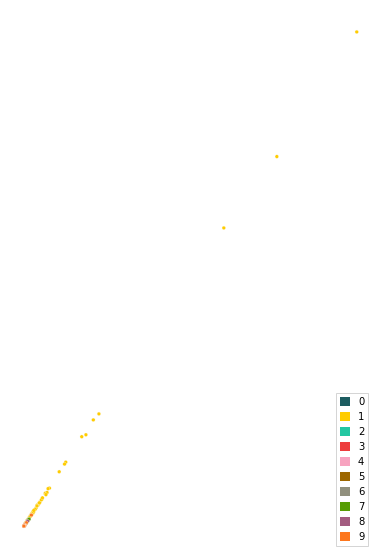

In [6]:
paradime.utils.scatterplot(
    foo.apply(testdata),
    testtargets,
)

In [26]:
tsne = paradime.dr.ParametricDR(
    global_relations=paradime.relations.NeighborBasedPDist(
        transform=[
            paradime.transforms.PerplexityBasedRescale(perplexity=100),
            paradime.transforms.Symmetrize(),
            paradime.transforms.Normalize(),
            ]
        ),
    batch_relations=paradime.relations.DifferentiablePDist(
            transform=[
                # paradime.transforms.StudentTTransform(alpha=1.),
                paradime.transforms.Functional(my_trafo),
                paradime.transforms.Normalize(),
                paradime.transforms.ToSquareTensor(),
            ]
        ),
    in_dim=28*28,
    out_dim=2,
    hidden_dims=[100,50],
    dataset=testdata,
    use_cuda=True,
    verbose=True,
)
tsne.add_to_dataset({
    'pca': torch.tensor(sklearn.decomposition.PCA(n_components=2).fit_transform(
        testdata), dtype=torch.float)
})
tsne.add_training_phase(
    name="pca_init",
    loss=paradime.loss.PositionLoss(position_key='pca'),
    batch_size=500,
    n_epochs=10,
    learning_rate=0.01,
)
tsne.add_training_phase(
    name="embedding",
    loss=paradime.loss.RelationLoss(
        loss_function=paradime.loss.kullback_leibler_div
    ),
    batch_size=500,
    n_epochs=40,
    learning_rate=0.1,
    report_interval=2,
)

2022-08-08 13:40:06,661: Registering dataset.
2022-08-08 13:40:06,785: Adding entry 'pca' to dataset.


2022-08-08 13:40:27,470: Computing global relations 'rel'.
2022-08-08 13:40:27,472: Indexing nearest neighbors.
2022-08-08 13:40:34,976: Calculating probabilities.
2022-08-08 13:40:35,471: Beginning training phase 'pca_init'.
2022-08-08 13:40:35,704: Loss after epoch 0: 23.748076617717743
2022-08-08 13:40:36,736: Loss after epoch 5: 0.14506406895816326
2022-08-08 13:40:37,586: Beginning training phase 'embedding'.
2022-08-08 13:40:38,597: Loss after epoch 0: 7.371754050254822
2022-08-08 13:40:40,744: Loss after epoch 2: 8.057094693183899
2022-08-08 13:40:42,816: Loss after epoch 4: 8.119584381580353
2022-08-08 13:40:44,908: Loss after epoch 6: 8.220088481903076
2022-08-08 13:40:47,270: Loss after epoch 8: 7.981883406639099
2022-08-08 13:40:49,399: Loss after epoch 10: 8.062251806259155
2022-08-08 13:40:51,509: Loss after epoch 12: 8.092309772968292
2022-08-08 13:40:53,732: Loss after epoch 14: 8.328361093997955
2022-08-08 13:40:55,862: Loss after epoch 16: 8.605918526649475
2022-08-08 

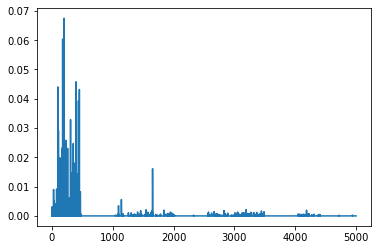

In [56]:
plt.plot(tsne.global_relation_data['rel'].data.toarray()[0])

In [69]:
a = tsne.global_relations['rel'].compute_relations(testdata)

2022-08-08 14:13:30,390: Indexing nearest neighbors.
2022-08-08 14:13:38,376: Calculating probabilities.


In [72]:
mine = a.data.toarray()

In [76]:
from openTSNE.affinity import PerplexityBasedNN
p = PerplexityBasedNN(data=testdata, perplexity=100)

In [73]:
his = p.P.toarray()

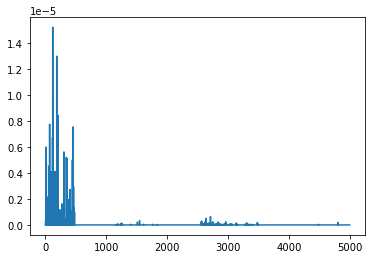

In [88]:
plt.plot(mine[4]/mine.sum())

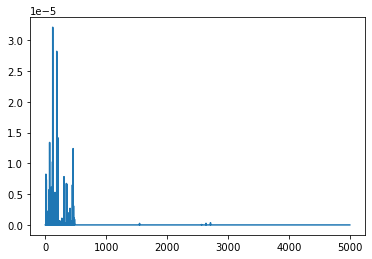

In [87]:
plt.plot(his[4])

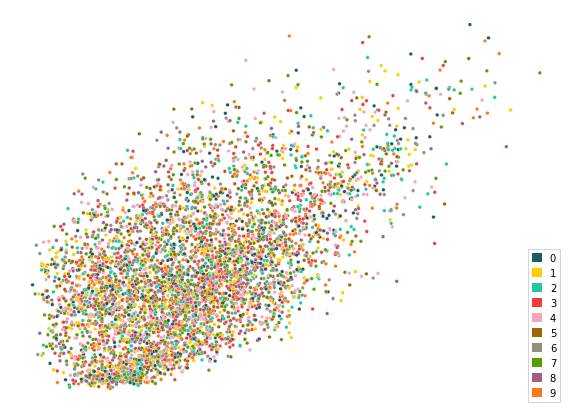

In [30]:
paradime.utils.scatterplot(tsne.apply(testdata), mnist.targets[:num_pts]);

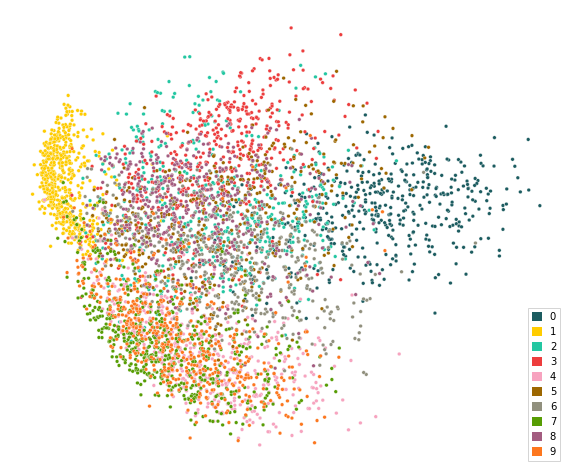

In [21]:
paradime.utils.scatterplot(
    tsne.dataset.data['pca'],
    testtargets,
);

In [22]:
dr = paradime.routines.ParametricUMAP(
    n_neighbors=100,
    dataset=testdata,
    verbose=True,
    use_cuda=True,
)
dr.train()

2022-08-08 13:03:56,740: Registering dataset.
2022-08-08 13:03:56,753: Computing global relations 'rel'.
2022-08-08 13:03:56,754: Indexing nearest neighbors.
2022-08-08 13:04:00,028: Calculating probabilities.
2022-08-08 13:04:04,086: Adding entry 'spectral' to dataset.
2022-08-08 13:04:04,087: Beginning training phase 'spectral_init'.
2022-08-08 13:04:04,320: Loss after epoch 0: 445.443996489048
2022-08-08 13:04:05,061: Beginning training phase 'embedding'.
2022-08-08 13:04:05,856: Loss after epoch 0: 25109.464076042175
2022-08-08 13:04:09,806: Loss after epoch 5: 1509.1316299438477
2022-08-08 13:04:13,741: Loss after epoch 10: 1507.1820831298828
2022-08-08 13:04:17,703: Loss after epoch 15: 1355.9247574806213
2022-08-08 13:04:21,682: Loss after epoch 20: 1535.792890548706
2022-08-08 13:04:25,680: Loss after epoch 25: 1437.8193340301514


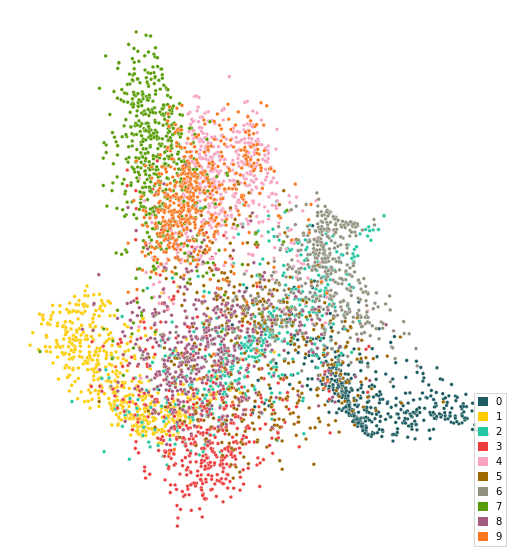

In [24]:
paradime.utils.scatterplot(
    dr.apply(testdata),
    testtargets
);

In [112]:
class EmbeddingClassificationHybrid(prdm.models.Model):

    def __init__(self,
        in_dim: int,
        class_dim: int,
        emb_dim: int,
        hidden_dims: list[int]
    ):
        super().__init__()
        
        self.layers = torch.nn.ModuleList()
        self.class_dim = class_dim
        
        cur_dim = in_dim
        for hdim in hidden_dims:
            self.layers.append(torch.nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.class_layer = torch.nn.Linear(cur_dim, class_dim)
        self.emb_layer = torch.nn.Linear(cur_dim, emb_dim)

    def common_forward(self, x):
        for layer in self.layers:
            # x = torch.sigmoid(layer(x))
            x = torch.nn.Softplus()(layer(x))
        return x

    def classify(self, x):
        x = self.common_forward(x)
        x = self.class_layer(x)
        x = torch.nn.Softmax(dim=1)(x)
        return x

    def embed(self, x):
        x = self.common_forward(x)
        x = self.emb_layer(x)
        return x

    def forward(self, x):
        return self.embed(x)    

In [118]:
mymodel = EmbeddingClassificationHybrid(28*28, 10, 2, [50, 50])

foo = prdm.ParametricDR(
    model=mymodel,
    dataset={
        'data': testdata,
        'labels': testtargets,
    },
    global_relations=prdm.relations.NeighborBasedPDist(
        transform=[
            prdm.transforms.PerplexityBasedRescale(
                perplexity=50
            ),
            prdm.transforms.Symmetrize()
        ]
    ),
    batch_relations=prdm.relations.DifferentiablePDist(
        transform=[
            prdm.transforms.StudentTTransform(alpha=1.),
            prdm.transforms.Normalize(),
            prdm.transforms.ToSquareTensor(),
        ]
    ),
    use_cuda=True,
    verbose=True,
)
foo.add_training_phase(prdm.TrainingPhase(
    name='main',
    n_epochs=30,
    batch_size=500,
    loss=prdm.loss.CompoundLoss([
        prdm.loss.RelationLoss(
            loss_function=prdm.loss.kullback_leibler_div
        ),
        prdm.loss.ClassificationLoss()
        ],
        weights=[1., 190.],
    )
))
foo.train()

2022-08-03 16:04:23.1: Registering dataset.
2022-08-03 16:04:23.1: Computing global relations 'rel'.
2022-08-03 16:04:23.1: Indexing nearest neighbors.
2022-08-03 16:04:27.7: Calculating probabilities.
2022-08-03 16:04:28.1: Beginning training phase 'main'.
2022-08-03 16:04:28.6: Loss after epoch 0: 7834.165466308594
2022-08-03 16:04:31.3: Loss after epoch 5: 6434.125244140625
2022-08-03 16:04:33.8: Loss after epoch 10: 6100.394226074219
2022-08-03 16:04:36.5: Loss after epoch 15: 6201.397705078125
2022-08-03 16:04:39.2: Loss after epoch 20: 6040.8719482421875
2022-08-03 16:04:41.8: Loss after epoch 25: 5873.6700439453125


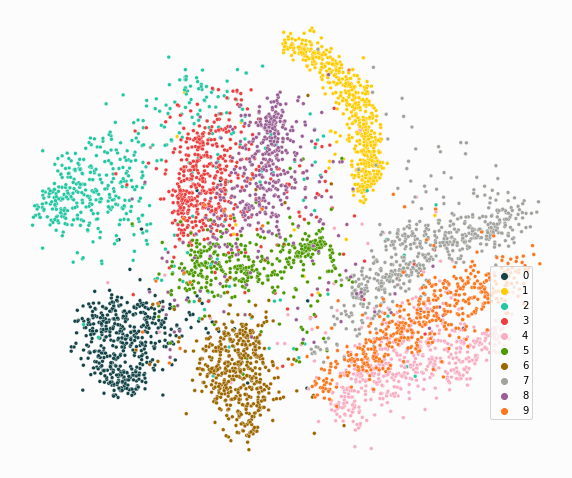

In [119]:
emb = foo.embed(testdata.cuda()).detach().cpu()
fig = plt.figure(figsize=(10,10))
fig.set_facecolor(paradime_colors['background'])
sp = sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=testtargets,
    s=14., alpha=1., edgecolor="white",  palette=paradime_palette)
sp.tick_params(bottom=False, left=False)
sp.set(xticklabels=[],yticklabels=[], aspect=1.)
sns.despine(top=True, left=True, bottom=True, right=True)
sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))

In [120]:
(foo.model.classify(testdata.cuda()).detach().cpu().argmax(dim=1).numpy() == testtargets).sum()

4418

In [122]:
a,b = [ lo.history for lo in foo.training_phases[0].loss.losses ]

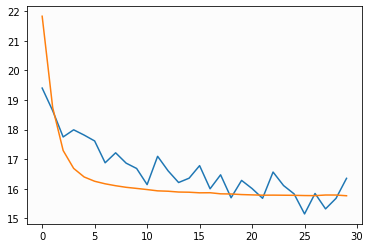

In [126]:
plt.plot(np.array(a)/190.)
plt.plot(b)

In [47]:
prdm.utils.seed_all(42)

dr = prdm.routines.ParametricTSNE(
    perplexity=100,
    dataset=testdata,
)
dr.train()

In [33]:
import seaborn as sns

In [44]:
def plot_result(data, labels):
    palette = sns.color_palette(prdm.utils.get_color_palette().values())
    fig = plt.figure(figsize=(10,10))
    sp = sns.scatterplot(
        x=data[:,0],
        y=data[:,1],
        hue=labels,
        s=14.,
        alpha=1.,
        edgecolor="white",
        palette=palette
    )
    sp.tick_params(bottom=False, left=False)
    sp.set(xticklabels=[],yticklabels=[], aspect=1.)
    sns.despine(top=True, left=True, bottom=True, right=True)
    sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))

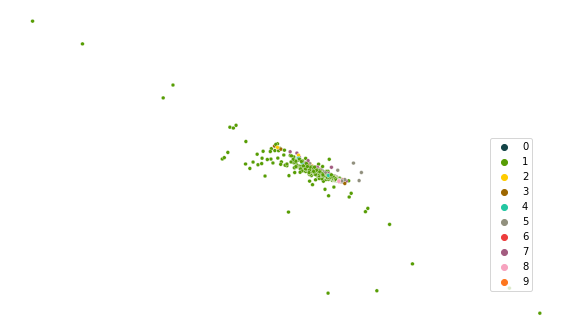

In [48]:
plot_result(dr(mnist.data.reshape(-1, 28*28) / 255.).detach(), mnist.targets)

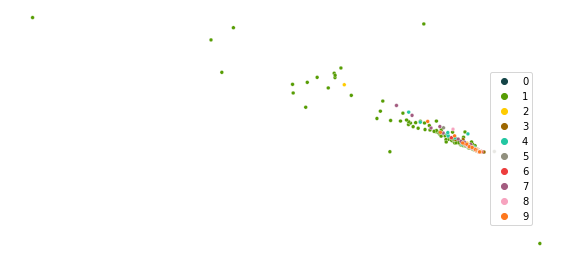

In [49]:
plot_result(dr(testdata).detach(), testtargets)

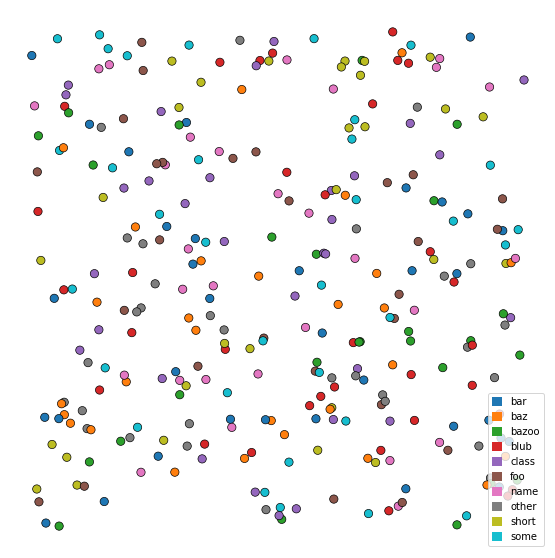

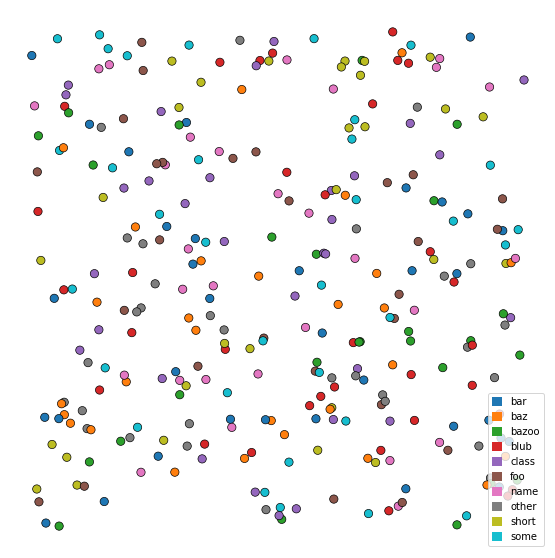

In [146]:
scatterplot(np.random.random((300,2)),labels=np.random.choice(dummy_classes,300),
colormap=list(matplotlib.colors.TABLEAU_COLORS.values()),edgecolor='black')